<a href="https://colab.research.google.com/github/Suhwan-Dev/github_test/blob/master/GAN_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network homework

##Import modules

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
from keras.optimizers import RMSprop
from keras import backend as K

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(50)
tf.random.set_seed(50)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")



##Import Fashion MNIST dataset

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


##Define networks

In [3]:
input_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[input_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1)                                                       # -> 변화
])

gan = keras.models.Sequential([generator, discriminator])

##Define losses

In [4]:
def wasserstein(yTrue, yPrdt):                                                  # -> 변화
    return -K.mean(yTrue * yPrdt)                                               # -> 변화

discriminator.compile(loss=wasserstein, optimizer=RMSprop(lr=0.00005))           # -> 변화
discriminator.trainable = False
gan.compile(loss=wasserstein, optimizer=RMSprop(lr=0.00005))                     # -> 변화

##Define dataset

Fashion MNIST dataset


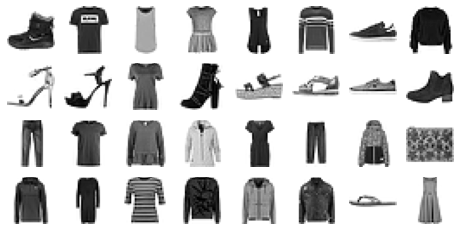

In [5]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale
batch_size = 32
print('Fashion MNIST dataset')
plot_multiple_images(X_train_dcgan[:batch_size], 8)

##Train GAN

Epoch 1/25000


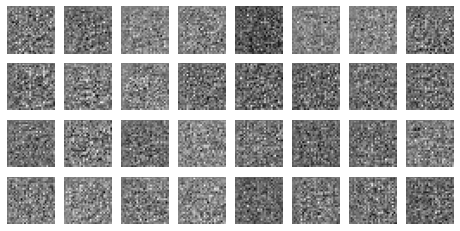

Epoch 1001/25000


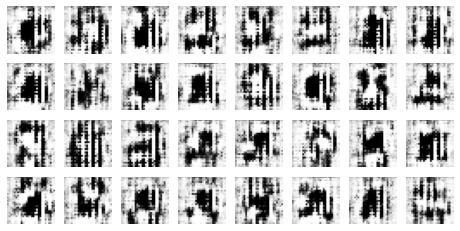

Epoch 2001/25000


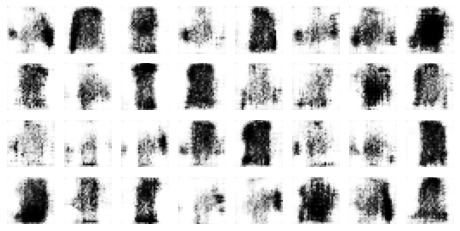

Epoch 3001/25000


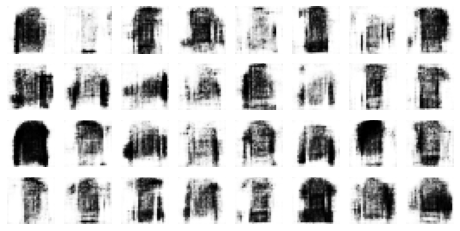

Epoch 4001/25000


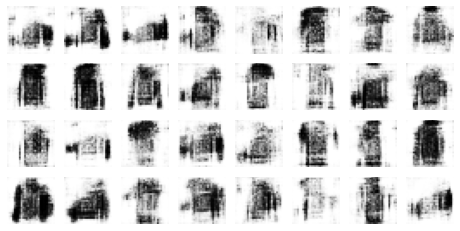

Epoch 5001/25000


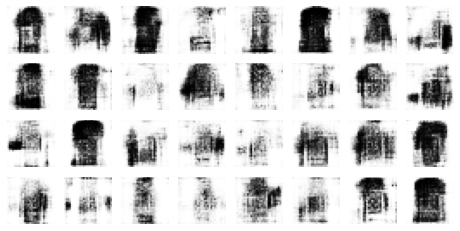

Epoch 6001/25000


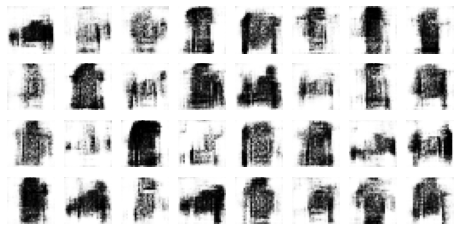

Epoch 7001/25000


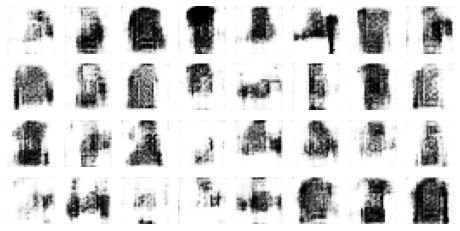

Epoch 8001/25000


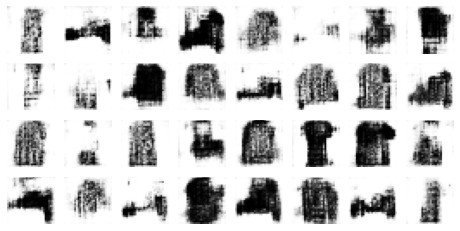

Epoch 9001/25000


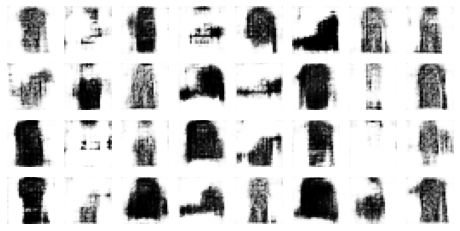

Epoch 10001/25000


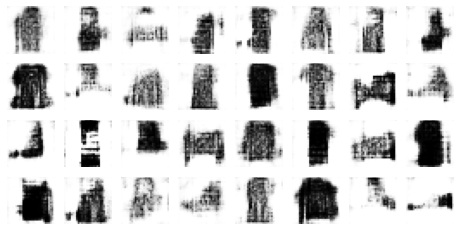

Epoch 11001/25000


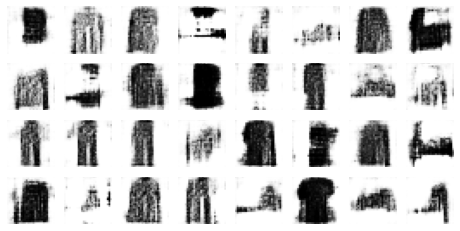

Epoch 12001/25000


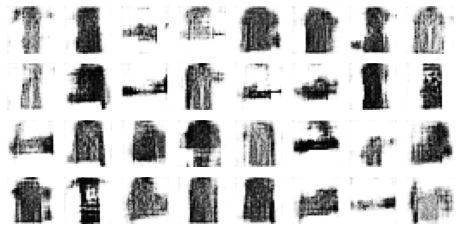

Epoch 13001/25000


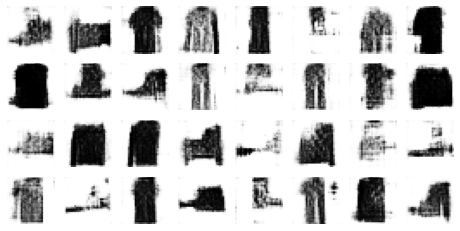

Epoch 14001/25000


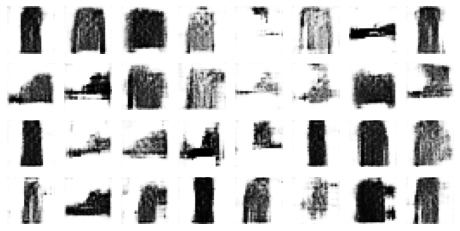

Epoch 15001/25000


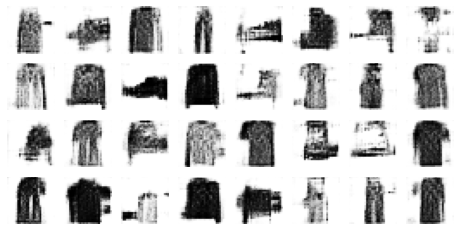

Epoch 16001/25000


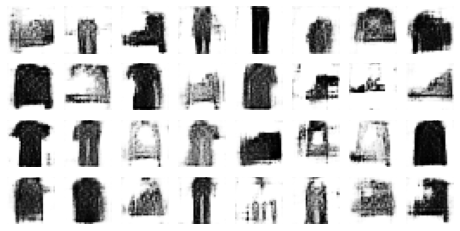

Epoch 17001/25000


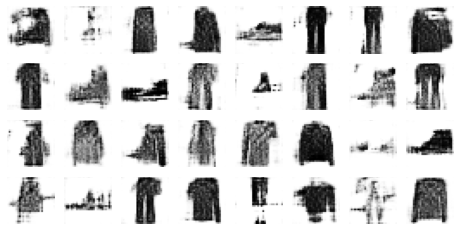

Epoch 18001/25000


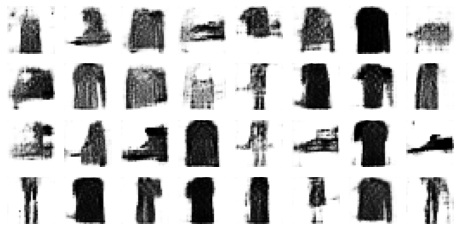

Epoch 19001/25000


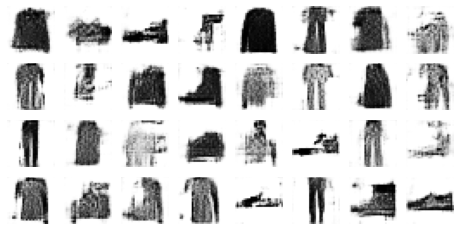

Epoch 20001/25000


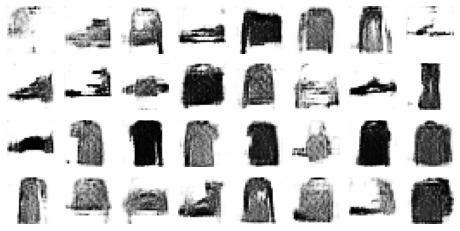

Epoch 21001/25000


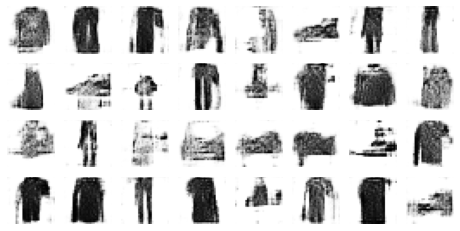

Epoch 22001/25000


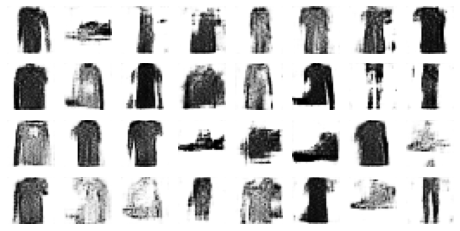

Epoch 23001/25000


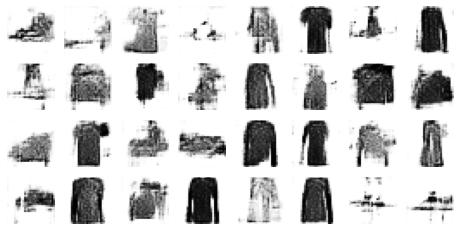

Epoch 24001/25000


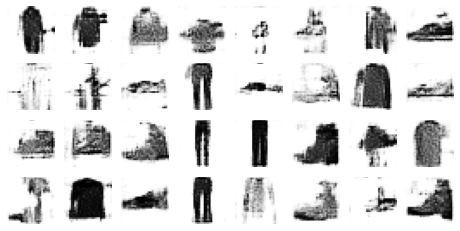

Epoch 25000/25000


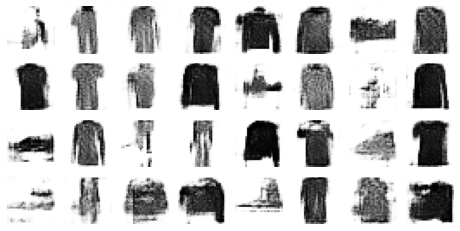

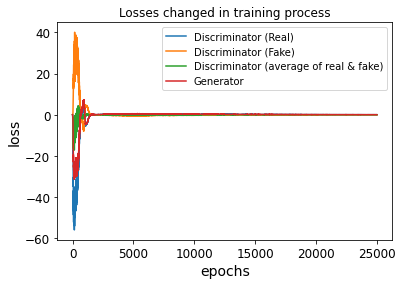

In [6]:
def trainWGAN(n_epochs, batch_size, sample_interval, clip_value):               # -> 변화
    # 정답으로 사용 할 매트릭스: real = 1, fake = -1.
    real = np.ones((batch_size, 1))
    fake = -np.ones((batch_size, 1))                                            # -> 변화
    history = []

    # 네트워크 훈련 for문
    for epoch in range(n_epochs):
        # ------------------------------------
        # phase 1 - training the discriminator
        # ------------------------------------        
        for _ in range(5):
            # 데이터에서 이미지와 라벨을 batch_size 크기로 무작위 추출
            idx = np.random.randint(0, X_train_dcgan.shape[0], batch_size)
            real_images = X_train_dcgan[idx]
            
            # random noise 샘플 생성
            noise = tf.random.normal(shape=[batch_size, input_size])  

            # 생성자에 random noise 샘플 입력하여, fake 이미지 생성
            generated_images = generator(noise) 

            # 판별자 학습
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch(real_images, real)      # real 판단 loss
            d_loss_fake = discriminator.train_on_batch(generated_images, fake) # fake 판단 loss
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)                    # 판별자의 판단 loss

            # clipping                                                          # -> 변화
            for l in discriminator.layers:                                      # -> 변화
                weights = l.get_weights()                                       # -> 변화
                weights = [np.clip(w, -clip_value, clip_value) for w in weights]# -> 변화
                l.set_weights(weights)                                          # -> 변화

        # ------------------------------------
        # phase 2 - training the generator
        # ------------------------------------

        # random noise 샘플 생성
        noise = tf.random.normal(shape=[batch_size, input_size])

        # 생성자에 random noise 샘플 입력하여, 판별자가 참이라고 판단하도록, 생성자 학습
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, real)

        # 훈련 과정 추적: loss 추적
        history.append({"Drl": d_loss_real, "Dfk": d_loss_fake, "D": d_loss, "G": g_loss})

        # 훈련 과정 추적: 생성자의 샘플 출력
        if (epoch%sample_interval == 0) or (epoch == n_epochs-1):
            print("Epoch {}/{}".format(epoch + 1, n_epochs))
            plot_multiple_images(generated_images, 8)
            plt.show()

    return(history)

# 네트워크 훈련
n_epochs = 25000                                                                # -> 변화
history = trainWGAN(n_epochs, batch_size, 1000, 0.01)                           # -> 변화

# 훈련 과정 추적: Plot loss
hist = pd.DataFrame(history)
print('')
print('=======================================')
plt.figure()
plt.plot(np.arange(n_epochs), hist['Drl'], label='Discriminator (Real)')
plt.plot(np.arange(n_epochs), hist['Dfk'], label='Discriminator (Fake)')
plt.plot(np.arange(n_epochs), hist['D'], label='Discriminator (average of real & fake)')
plt.plot(np.arange(n_epochs), hist['G'], label='Generator')
plt.legend()
plt.title('Losses changed in training process')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()
